<a href="https://colab.research.google.com/github/ZoraizQ/brain_mas_classifier/blob/master/brain_mas_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifier for Human Brain Mental Attention State using EEG BCI-based data

In [66]:
import os
import random
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
import seaborn as sns



import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import AveragePooling2D
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam, RMSprop
from keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


SAMP_FREQ = 128 # SAMPLING FREQUENCY Hz (samples/second)
CLASSES = {
    0: 'focused',
    1: 'unfocused',
    2: 'drowsy'
}

ONEHOT = {
    0: np.array([1,0,0]),
    1: np.array([0,1,0]),
    2: np.array([0,0,1])
}

## Dataset Load & Visualize

In [67]:
! [ ! -f '/content/eeg-data.zip' ] && gdown 'https://drive.google.com/uc?id=163LQWJzuyUy5nQlNsLWg4o-IiQJ72IbN'
! [ ! -d '/content/data' ] && unzip '/content/eeg-data.zip' -d '/content/data' 

In [68]:
DATA_FOLDER = '/content/data'

filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.mat')))

NUM_FILES_ALL = len(filenames) # with habituation and trial experiments both
print("Total number of records: " + str(NUM_FILES_ALL))

'''
Each participant took part in 7 experiments, performing at most one experiment per day. 
The first 2 experiments were used for habituation, and the last 5 trials were used for collecting the data. 
The first 7 experiments belong to Subject 1, the next 7 experiments belong to Subject 2, and go on. 
However, Subject 5 could not complete the last experiment. 
Therefore, there are 34 records in the dataset.
'''


img_folder_path = '/'.join(filenames[0].split('/')[:-1])
filenames_trials = []  # remove records of habituation first, second of each subject's set out of 7
for i in range(3, NUM_FILES_ALL, 7):
    for j in range(i, min(i+5, NUM_FILES_ALL+1)):
        filenames_trials.append(img_folder_path+'/'+'eeg_record'+str(j)+'.mat')

print(filenames_trials)
NUM_FILES = len(filenames_trials)
print("Number of trial experiment records: " + str(NUM_FILES))

Total number of records: 34
['/content/data/EEG Data/eeg_record3.mat', '/content/data/EEG Data/eeg_record4.mat', '/content/data/EEG Data/eeg_record5.mat', '/content/data/EEG Data/eeg_record6.mat', '/content/data/EEG Data/eeg_record7.mat', '/content/data/EEG Data/eeg_record10.mat', '/content/data/EEG Data/eeg_record11.mat', '/content/data/EEG Data/eeg_record12.mat', '/content/data/EEG Data/eeg_record13.mat', '/content/data/EEG Data/eeg_record14.mat', '/content/data/EEG Data/eeg_record17.mat', '/content/data/EEG Data/eeg_record18.mat', '/content/data/EEG Data/eeg_record19.mat', '/content/data/EEG Data/eeg_record20.mat', '/content/data/EEG Data/eeg_record21.mat', '/content/data/EEG Data/eeg_record24.mat', '/content/data/EEG Data/eeg_record25.mat', '/content/data/EEG Data/eeg_record26.mat', '/content/data/EEG Data/eeg_record27.mat', '/content/data/EEG Data/eeg_record28.mat', '/content/data/EEG Data/eeg_record31.mat', '/content/data/EEG Data/eeg_record32.mat', '/content/data/EEG Data/eeg_re

data: (357224, 25)


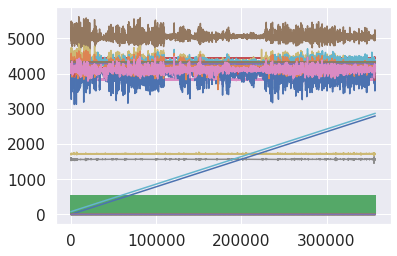


data_eeg: (357224, 14)


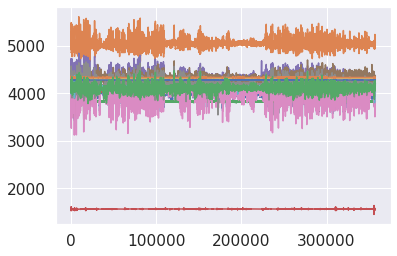


trials: (1, 2, 14, 128)

data: (380344, 25)


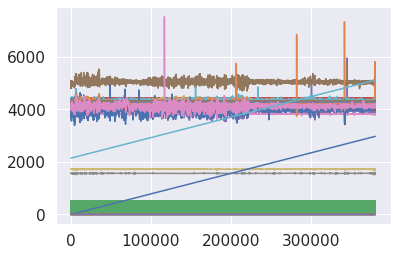


data_eeg: (380344, 14)


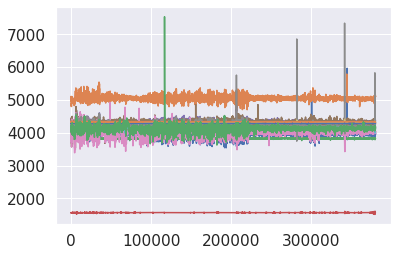


trials: (1, 2, 14, 128)

data: (351204, 25)


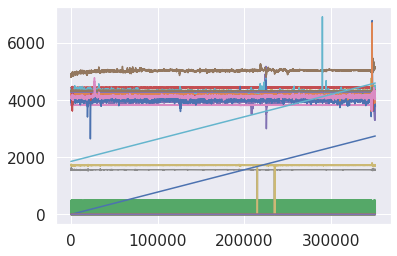


data_eeg: (351204, 14)


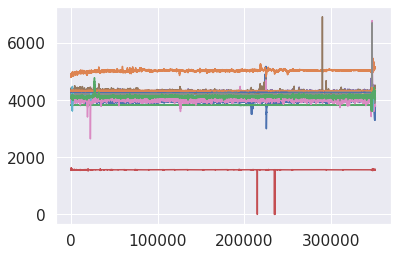


trials: (1, 2, 14, 128)

data: (288752, 25)


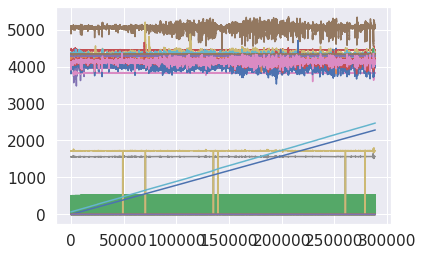


data_eeg: (288752, 14)


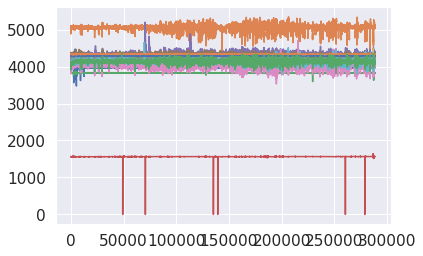


trials: (1, 2, 14, 128)

data: (398816, 25)


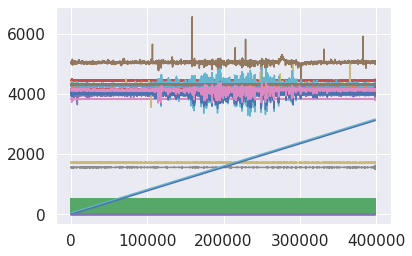


data_eeg: (398816, 14)


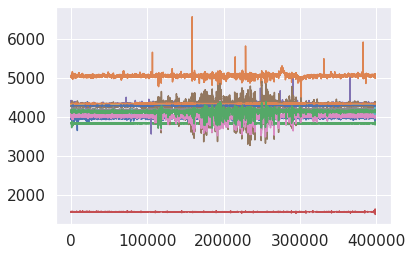


trials: (1, 3, 14, 128)



In [80]:
'''
Each Matlab file contains the object of the data acquired from EMOTIV device during one experiment. 
The raw data is contained in o.data, which is array of size {number-of-samples}x25, thus o.data(:,i) comprises one data channel. 
The sampling frequency is 128 Hz. The list of data channels and their numerical ids is given below per EMOTIV documentation;

25 CHANNELS:

1-'EDCOUNTER' 2-'EDINTERPOLATED'
3-'EDRAWCQ'
------------
4-'EDAF3' 5-'EDF7'
6-'EDF3' 7-'EDFC5'
8-'EDT7' 9-'EDP7'
10-'EDO1' 11-'EDO2'
12-'EDP8' 13-'EDT8'
14-'EDFC6' 15-'EDF4'
16-'EDF8' 17-'EDAF4'
--------------
18-'EDGYROX' 19-'EDGYROY'
20-'EDTIMESTAMP' 21-'EDESTIMESTAMP' 22-'EDFUNCID' 23-'EDFUNCVALUE' 24-'EDMARKER'
25'EDSYNCSIGNAL'

The EEG data is in the channels 4:17.

'''

for i in range(5):
    record = loadmat(filenames_trials[i])
    mdata = record['o']  # main object 
    sample1 = {n: mdata[n][0,0] for n in mdata.dtype.names}

    data = sample1['data']
    trials = sample1['trials']

    print('data:', data.shape)
    plt.plot(data)
    plt.show()

    data_eeg = data[:,4:18]
    print('\ndata_eeg:', data_eeg.shape)
    plt.plot(data_eeg)
    plt.show()

    print('\ntrials:', trials.shape)
    print()

## Data Partitioning

In [85]:
x = []
y = []

'''
Every experiments have same labels:
Focuse: 0 to 10 min
Unfocused: 10 to 20min
Sleep: 20 to end of experiments
'''

TRIAL_SECONDS = 6
MARK_10MIN, MARK_20MIN = 10*60*SAMP_FREQ, 20*60*SAMP_FREQ 
TRIAL_LENGTH = TRIAL_SECONDS*SAMP_FREQ
NUM_TRIALS = MARK_10MIN//TRIAL_LENGTH
NUM_CHAN = 14
NOISE_POWER = 0.005


print(MARK_10MIN, TRIAL_LENGTH, NUM_TRIALS)

# def mean_normalize(x): # per-channel mean normalization
#     mu = np.mean(x, axis=1)
#     mu = mu.reshape(mu.shape+(1,))
#     sigma = np.std(x, axis=1)
#     sigma = sigma.reshape(sigma.shape+(1,))
    
#     # noise = NOISE_POWER * np.random.randn(*x.shape)
#     x = (x - mu) / sigma # + noise
#     return x

def feature_scaling(x): # same standard scalar as mean
    std_scale = preprocessing.StandardScaler().fit(x)
    return std_scale.transform(x)


for fn in filenames_trials:
    record = loadmat(fn)
    mdata = record['o']  # main object 
    ndata = {n: mdata[n][0,0] for n in mdata.dtype.names}
    
    data = ndata['data'][:,4:18] # 4-17 EEG data channels only
    ns = data.shape[0]

    focused = np.array(data[:MARK_10MIN])
    focused = feature_scaling(focused)

    focused_trials = np.split(focused, NUM_TRIALS)

    x += focused_trials # from the start
    y += [ONEHOT[0]]*NUM_TRIALS # focused


    unfocused = data[MARK_10MIN:MARK_20MIN]
    unfocused = feature_scaling(unfocused)

    unfocused_trials = np.split(unfocused, NUM_TRIALS)
    x += unfocused_trials
    y += [ONEHOT[1]]*NUM_TRIALS # unfocused


    drowsy = data[MARK_20MIN:]
    drowsy = feature_scaling(drowsy)

    min_splits = drowsy.shape[0]//TRIAL_LENGTH
    drowsy = drowsy[:min_splits*TRIAL_LENGTH]
    drowsy_trials = np.split(drowsy, min_splits) # for the entire drowsy duration split it into trials
    x += drowsy_trials# until the end, 
    y += [ONEHOT[2]]*min_splits # drowsy


print(len(x), len(y))

76800 768 100
11710 11710


In [87]:
TOTAL_SAMPLES = len(x)
TEST_RATIO = 0.2

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TEST_RATIO, random_state=42)

x_train_list = x_train
x_train = np.array(x_train)
x_train = np.reshape(x_train, (*x_train.shape, 1))
y_train = np.array(y_train)

x_test = np.array(x_test)
x_test = np.reshape(x_test, (*x_test.shape, 1))
y_test = np.array(y_test)

print(x_train.shape, y_train.shape)

(9368, 768, 14, 1) (9368, 3)


focused (768, 14)


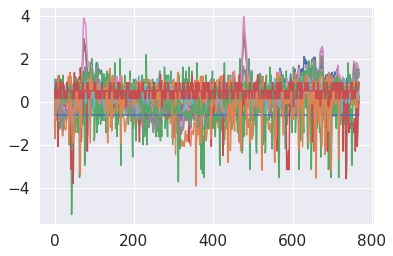


focused (768, 14)


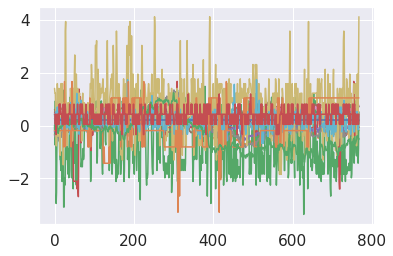


unfocused (768, 14)


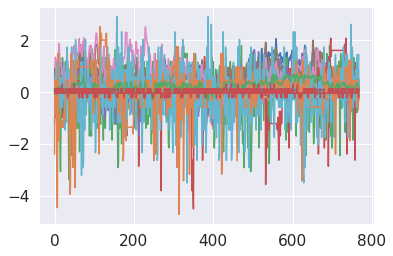


drowsy (768, 14)


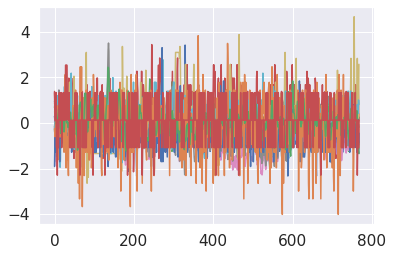


focused (768, 14)


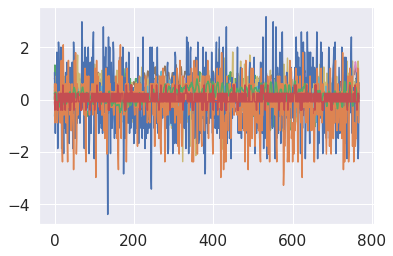


drowsy (768, 14)


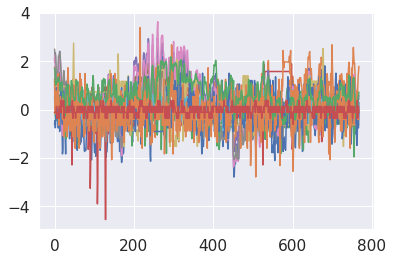


drowsy (768, 14)


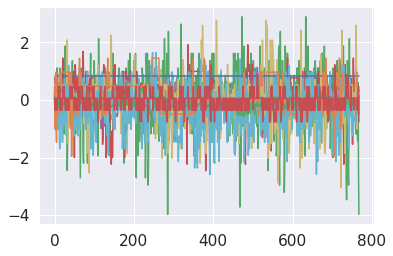


drowsy (768, 14)


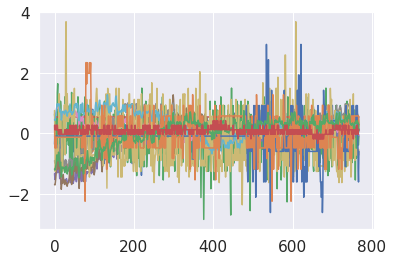


drowsy (768, 14)


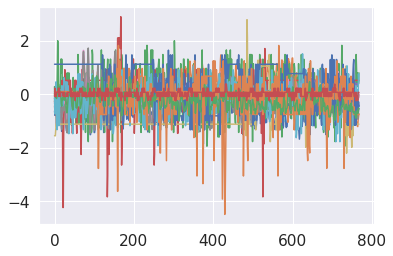


focused (768, 14)


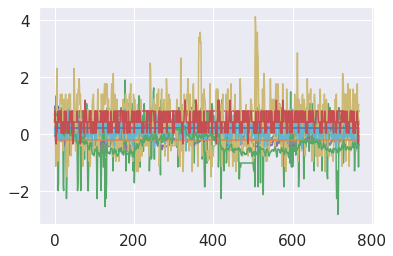

In [89]:
for i in range(10):
    print(CLASSES[np.argmax(y_train[i])], x_train_list[i].shape)
    plt.plot(x_train_list[i])
    plt.show()
    print()

## Models & Helpers

In [90]:
def create_CNN1(nchan, nclasses, trial_length=1024, l1=0, lr=1e-4):
    POOLING_STRIDES = 30

    input_shape = (trial_length, nchan, 1)
    model = Sequential()

    model.add(Conv2D(64, (60, 1), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="same", input_shape=input_shape)) # temporal convolution (30,1) 40 filters
    model.add(Conv2D(64, (1, nchan), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="valid")) # spatial convolution, inside bounds so no padding (1, 14) 40 filters

    model.add(AveragePooling2D((60, 1), strides=(POOLING_STRIDES, 1)))
    model.add(Dropout(0.35))

    model.add(Flatten())


    model.add(Dense(1500, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(300, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(80, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(nclasses, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer=Adam(lr), metrics=["accuracy"])

    return model


def create_CNN4(nchan, nclasses, trial_length=1024, l1=0, lr=1e-4):
    POOLING_STRIDES = 15

    input_shape = (trial_length, nchan, 1)
    model = Sequential()

    model.add(Conv2D(40, (30, 1), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="same", input_shape=input_shape)) # temporal convolution (30,1) 40 filters
    model.add(Conv2D(40, (1, nchan), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="valid")) # spatial convolution, inside bounds so no padding (1, 14) 40 filters
    model.add(AveragePooling2D((30, 1), strides=(POOLING_STRIDES, 1)))
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(80, activation="relu"))
    model.add(Dropout(0.35))

    model.add(Dense(nclasses, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer=Adam(lr), metrics=["accuracy"])

    return model



def create_CRNN1(nchan, nclasses, trial_length=1024, l1=0, lr=1e-4, full_output=False):
    input_shape = (trial_length, nchan, 1)
    model = Sequential()
    model.add(Conv2D(40, (30, 1), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="same", input_shape=input_shape))
    model.add(Conv2D(40, (1, nchan), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="valid"))
    model.add(AveragePooling2D((5, 1), strides=(5, 1)))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(40, activation="sigmoid", dropout=0.25, return_sequences=full_output))

    model.add(Dense(15, activation="relu"))

    model.add(Dense(nclasses, activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer=Adam(lr), metrics=["accuracy"])
    return model



def create_CRNN4(nchan, nclasses, trial_length=1024, l1=0, lr=1e-4, full_output=False):
    input_shape = (trial_length, nchan, 1)
    model = Sequential()
    model.add(Conv2D(40, (30, 1), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="same", input_shape=input_shape))
    model.add(Conv2D(40, (1, nchan), activation="relu", kernel_regularizer=regularizers.l1(l1), padding="valid"))
    model.add(AveragePooling2D((5, 1), strides=(5, 1)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(40, activation="sigmoid", dropout=0.25, return_sequences=full_output))
    model.add(Dense(nclasses, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer=Adam(lr), metrics=["accuracy"])
    return model


In [100]:
def plot_accuracy_loss(history):
    # accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def plot_confusion_matrix(conf_mat, classes):
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
    plt.show()


def plot_confusion_matrix_from_pred(pred, y_test):
    y_pred = []
    y_true = []

    for p in pred: 
        y_pred.append(np.argmax(p)) # softmax argmax for classification

    for p in y_test: 
        y_true.append(np.argmax(p)) # softmax argmax for classification


    y_pred = np.array(y_pred)

    print(len(y_pred))
    conf_mat = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(conf_mat, ['focused','unfocused','drowsy'])

## Compile & Train

In [92]:
LR = 1e-5
LR2 = 5e-5
BATCH_SIZE = 16
VAL_SPLIT = 0.2

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

def checkpoint_callback(name):
  return ModelCheckpoint(name+'.h5', monitor='val_loss', mode='min', save_best_only=True)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 768, 14, 40)       1240      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 768, 1, 40)        22440     
_________________________________________________________________
average_pooling2d_2 (Average (None, 50, 1, 40)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 1, 40)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 80)                160080    
_________________________________________________________________
dropout_5 (Dropout)          (None, 80)               

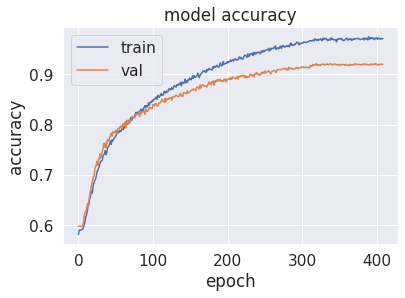

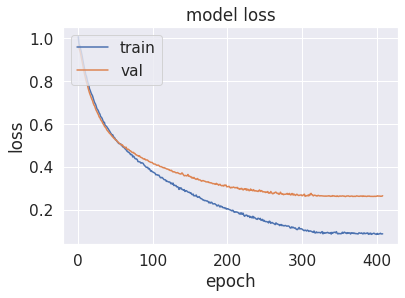

INFO:tensorflow:Assets written to: cnn4/assets


In [93]:
cnn4 = create_CNN4(nchan=NUM_CHAN, nclasses=len(CLASSES), trial_length=TRIAL_LENGTH, lr=LR)
cnn4.summary()

history = cnn4.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=5000, 
                         validation_split=VAL_SPLIT, shuffle=True, callbacks=[es, reduce_lr, checkpoint_callback('cnn4')])
plot_accuracy_loss(history)
cnn4.save('cnn4')
cnn4.save_weights('cnn4_weights.hdf5')

147/147 [==============================] - 1s 4ms/step - loss: 0.2603 - accuracy: 0.9189
test loss, test acc: [0.26028841733932495, 0.9188727736473083]
2342


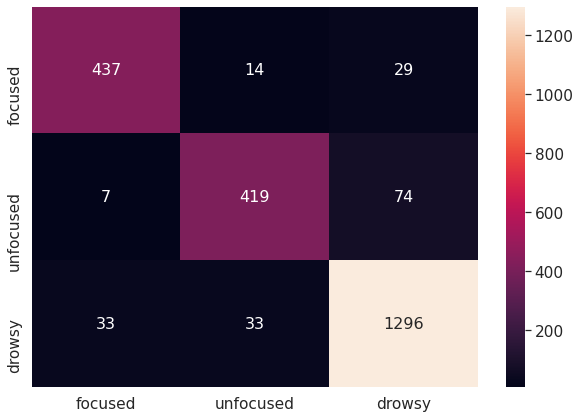

In [102]:
results = cnn4.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)
pred = cnn4.predict(x_test)
plot_confusion_matrix_from_pred(pred, y_test)

In [106]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 768, 14, 40)       1240      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 768, 1, 40)        22440     
_________________________________________________________________
average_pooling2d_8 (Average (None, 153, 1, 40)        0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 153, 40)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 123       
Total params: 36,763
Trainable params: 36,763
Non-trainable params: 0
__________________________________________________

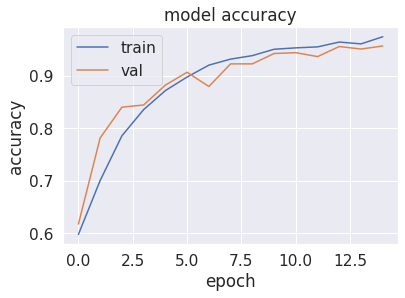

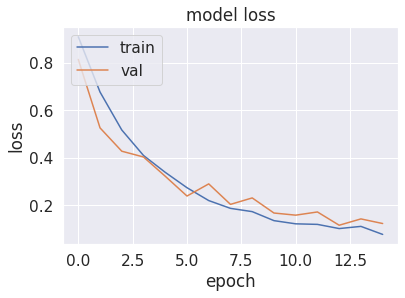

In [107]:
crnn4 = create_CRNN4(nchan=NUM_CHAN, nclasses=len(CLASSES), trial_length=TRIAL_LENGTH, lr=LR2)
crnn4.summary()

history = crnn4.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=40, 
                          validation_split=VAL_SPLIT, shuffle=True, callbacks=[es, reduce_lr, checkpoint_callback('crnn1')])
plot_accuracy_loss(history)

147/147 [==============================] - 3s 19ms/step - loss: 0.1303 - accuracy: 0.9573
test loss, test acc: [0.13032563030719757, 0.9573014378547668]
2342


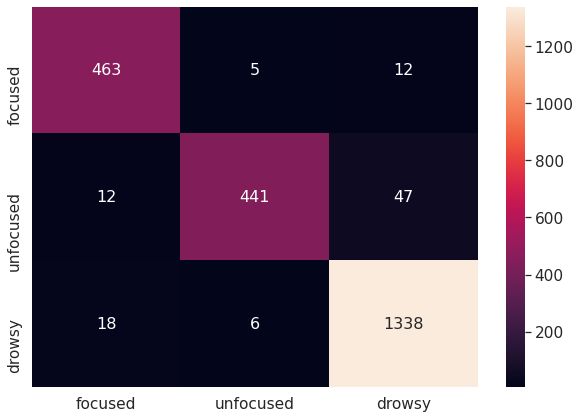

In [109]:
results = crnn4.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)
pred = crnn4.predict(x_test)
plot_confusion_matrix_from_pred(pred, y_test)

In [ ]:
crnn1 = create_CRNN1(nchan=NUM_CHAN, nclasses=len(CLASSES), trial_length=TRIAL_LENGTH, lr=LR2)
crnn1.summary()

history = crnn1.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=40, 
                          validation_split=VAL_SPLIT, shuffle=True, callbacks=[es, reduce_lr, checkpoint_callback('crnn1')])
plot_accuracy_loss(history)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 768, 14, 40)       1240      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 768, 1, 40)        22440     
_________________________________________________________________
average_pooling2d_9 (Average (None, 153, 1, 40)        0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 153, 40)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dense_15 (Dense)             (None, 15)                615       
_________________________________________________________________
dense_16 (Dense)             (None, 3)                

In [ ]:
results = crnn1.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)
pred = crnn1.predict(x_test)
plot_confusion_matrix_from_pred(pred, y_test)